### Tải các thư viện cần thiết

In [ ]:
%%capture
!pip uninstall neuralforecast

Found existing installation: neuralforecast 0.1.0
Uninstalling neuralforecast-0.1.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/neuralforecast-0.1.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/neuralforecast/*
Proceed (Y/n)? ERROR: Operation cancelled by user


In [ ]:
!pip install hyperopt

### Import các thư viện cần thiết

In [ ]:
import torch as t
import numpy as np
import pandas as pd
import seaborn as sns
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import neuralforecast as nf
from neuralforecast.auto import NHITS
from neuralforecast.losses.numpy import mae, mse
# from neuralforecast.data.datasets.long_horizon import LongHorizon

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [ ]:
import timeit

class CodeTimer:
    def __init__(self, name=None, verbose=True):
        self.name = " '"  + name + "'" if name else ''
        self.verbose = verbose

    def __enter__(self):
        self.start = timeit.default_timer()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (timeit.default_timer() - self.start)
        if self.verbose:
            print('Code block' + self.name + \
                  ' took:\t{0:.5f}'.format(self.took) + ' seconds')

In [ ]:
# check is using cuda(gpu)
t.cuda.is_available()

True

### 1.Áp dụng mô hình để dự đoán cho dữ liệu về giá vàng

In [ ]:
# Tải dữ liệu từ dataset
df_gold = pd.read_csv('/content/sample_data/gold_price_2018_2024.csv')

df_gold.index += 1

In [ ]:
df_gold.head()

,Date,Value (USD per troy ounce)
1,2018-01-01,1307.018690
2,2018-01-02,1319.827953
3,2018-01-03,1311.501862
4,2018-01-04,1321.635371
5,2018-01-05,1319.589185


In [ ]:
# Chuyển đổi kiểu dữ liệu
df_gold['Date'] = pd.to_datetime(df_gold['Date'])

# Xoá dữ liệu bị null
df_gold = df_gold.dropna()

# Gán lại tên cột cho dữ liệu
df_gold.columns = ['Date', 'Price']

df_gold

,Date,Price
1,2018-01-01,1307.018690
2,2018-01-02,1319.827953
3,2018-01-03,1311.501862
4,2018-01-04,1321.635371
5,2018-01-05,1319.589185
...,...,...
2248,2024-02-26,2031.609404
2249,2024-02-27,2033.313814
2250,2024-02-28,2032.653770
2251,2024-02-29,2036.199141


#### Chia tập huấn luyện, tập kiểm tra

In [ ]:
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
# Dữ liệu huấn luyện được chia thành các phần 9, 8, 7 ứng với các tỉ lệ test/train là 9:1, 8:2, 7:3
g_train_data_9 = df_gold[:2026]
g_train_data_8 = df_gold[:1800]
g_train_data_7 = df_gold[:1576]
g_train_data_9.columns = ['Date','Train Price']
g_train_data_8.columns = ['Date','Train Price']
g_train_data_7.columns = ['Date','Train Price']

# Dữ liệu  được chia thành các phần 1, 2, 3 ứng với các tỉ lệ test/train là 9:1, 8:2, 7:3
g_test_data_1 = df_gold[2026:]
g_test_data_2 = df_gold[1800:]
g_test_data_3 = df_gold[1576:]

g_test_data_1.columns = ['Date','Actual Price']
g_test_data_2.columns = ['Date','Actual Price']
g_test_data_3.columns = ['Date', 'Actual Price']

#### 1.1 Tỉ lệ train 9:1

##### Vẽ biểu đồ

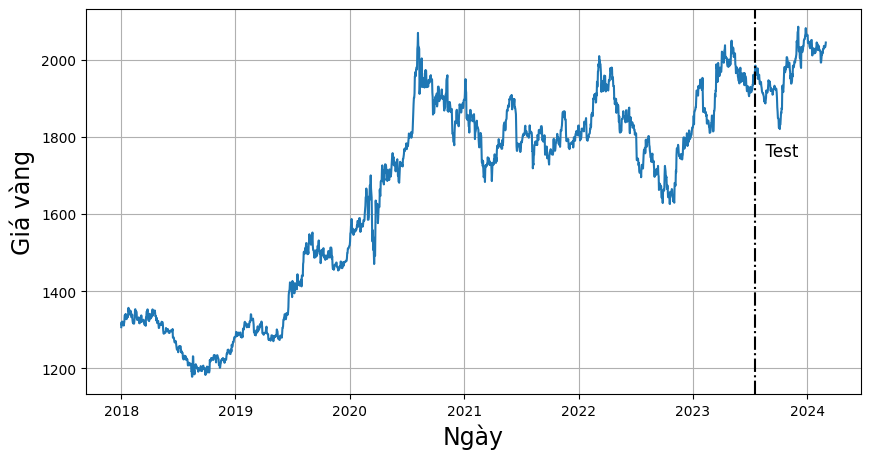

In [ ]:
x_plot = pd.to_datetime(df_gold.Date)
y_plot = df_gold.Price.values

x_value = x_plot[2026]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.xlabel('Ngày', fontsize=17)
plt.ylabel('Giá vàng', fontsize=17)

plt.axvline(x_value, color='black', linestyle='-.')
plt.text(x_value, 1750, '  Test', fontsize=12)

plt.grid()
plt.show()
plt.close()

##### Xác không gian siêu tham số

In [ ]:
X_train_9 = g_train_data_9[['Date']]  # Assuming 'Date' is the feature
y_train_9 = g_train_data_9['Train Price']
X_test_1 = g_test_data_1[['Date']]
y_test_1 = g_test_data_1['Actual Price']


In [ ]:
n_time_out = 30
input_size = 3 * n_time_out
space = {
    'max_steps': hp.choice('max_steps', [1000, 2000, 3000]),
    'num_blocks': hp.choice('num_blocks', [1, 2, 3]),
    'num_layers': hp.choice('num_layers', [2, 3, 4]),
    'num_neurons': hp.choice('num_neurons', [64, 128, 256]),
    'X_train': X_train_9,
    'y_train': y_train_9,
    'X_test': X_test_1,
    'y_test': y_test_1,
    'n_ts_value': len(X_test_1) / len(X_train_9)
}

# Define the objective function for optimization
def objective(params):
    model = nf.auto.NHITS(
        h=n_time_out,
        input_size=input_size,
        max_steps=params['max_steps'],
        num_blocks=params['num_blocks'],
        num_layers=params['num_layers'],
        num_neurons=params['num_neurons'],
    )
    model.fit(Y_df=Y_df,
              X_df=None,                             # Exogenous variables
              S_df=None,                             # Static variables
              hyperopt_steps=5,                      # Using 5 hyperopt steps
              n_ts_test=n_ts_test,                   # ETTm2's test set
              results_dir='./results/autonhits',
              save_trials=True,
              loss_function_val=nf.losses.numpy.mae, # MSE, QL, MQL, sMAPE ...
              loss_functions_test={'mae':nf.losses.numpy.mae,
                                  'mse':nf.losses.numpy.mse},
              return_test_forecast=True,
              verbose=False)

    model.fit(params['X_train'], params['y_train'])

    # Predict the target variable for the test data
    predictions = model.predict(len(params['X_test']))

    # Calculate the mean squared error (MSE) between the predictions and the actual values
    mse = mean_squared_error(params['y_test'], predictions)

    return {'loss': mse, 'status': STATUS_OK}

# Run Hyperopt optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
)

print("Best hyperparameters:", best)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO:lightning_fabric.utilities.seed:Seed set to 1
ERROR:hyperopt.fmin:job exception: 'DataFrame' object has no attribute 'temporal_cols'


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


AttributeError: 'DataFrame' object has no attribute 'temporal_cols'

#### 1.2 Tỉ lệ train, 8:2

##### Kiểm tra tính dừng của dữ liệu

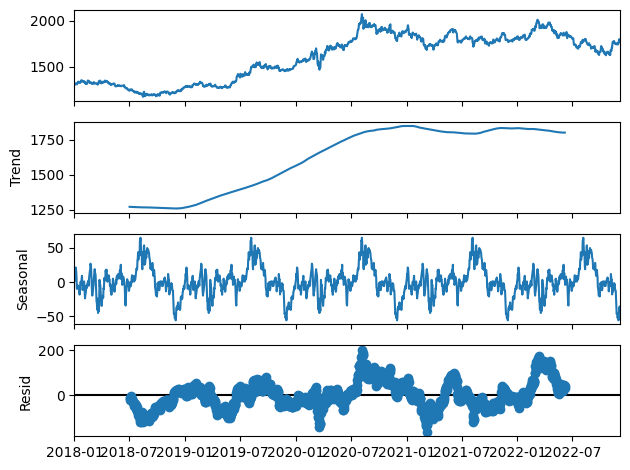

In [ ]:
# kiểm tra dữ liệu có bị tính mùa vụ hay không
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(g_train_data_8, model = 'additive', period=365)
fig = decomposition.plot()
plt.show()

In [ ]:
# Thực hiện kiểm định dickey-fuller trên tập dữ liệu huấn luyện
adftest = adfuller(g_train_data_8)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest[1])

if(adftest[1] < 0.05):
  print("=> Dữ liệu giá vàng dừng")
else:
  print("=> Dữ liệu giá vàng không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  0.6747242243545812
=> Dữ liệu giá vàng không dừng


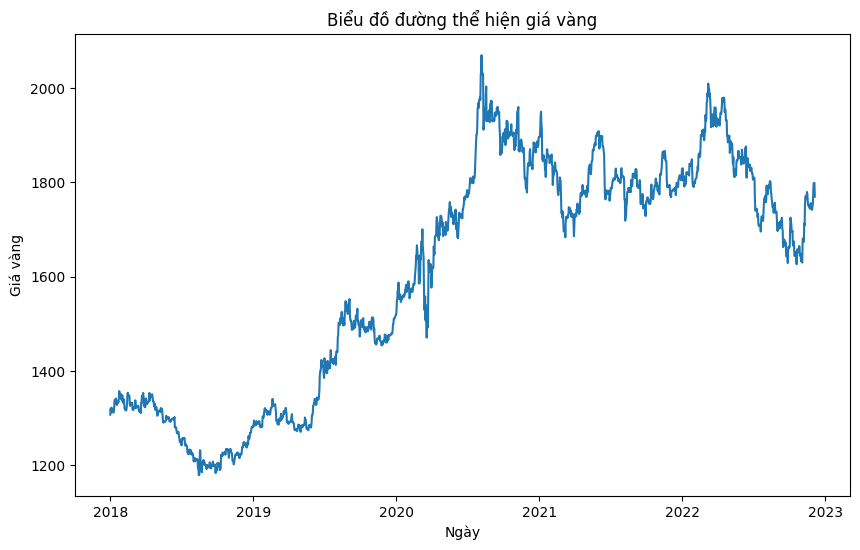

In [ ]:
# Biểu đồ dữ liệu giá vàng ban đầu
plt.figure(figsize=(10, 6))
plt.plot(g_train_data_8.index, g_train_data_8['Train Price'])
plt.title('Biểu đồ đường thể hiện giá vàng')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.show()

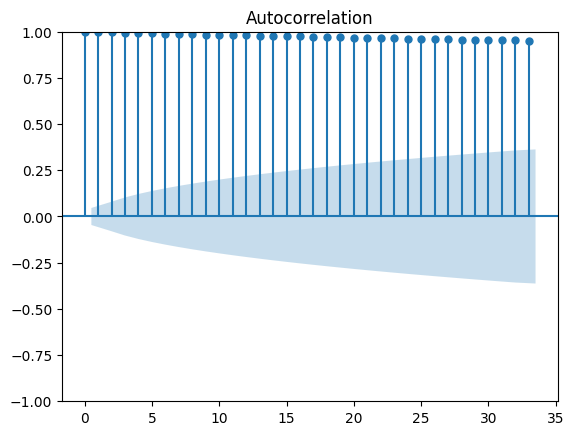

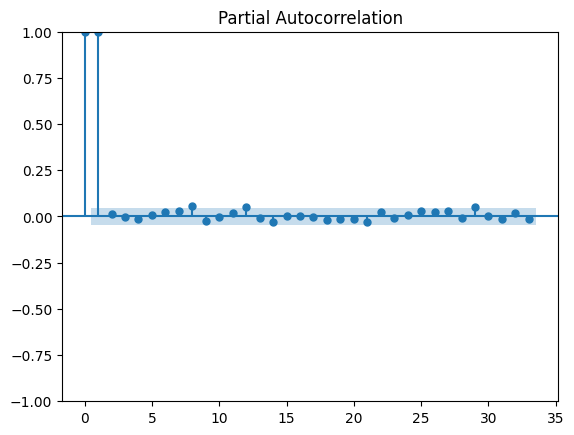

In [ ]:
# Đồ thị acf
origin_acf = plot_acf(g_train_data_8)
origin_pacf = plot_pacf(g_train_data_8)

##### Lấy sai phân lần 1

<Axes: xlabel='Date'>

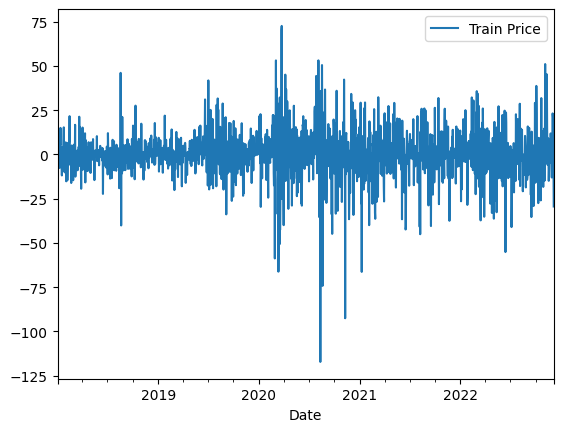

In [ ]:
# Vẽ biểu đồ sau khi lấy sai phân
first_diff = g_train_data_8.diff().dropna()
first_diff.plot()

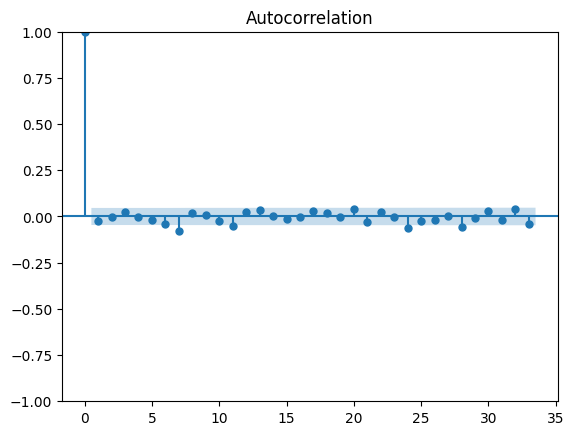

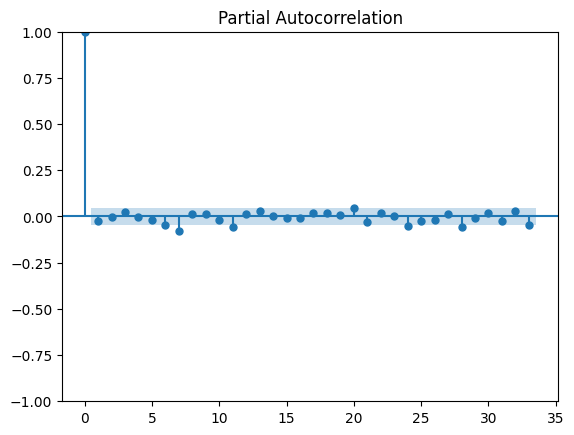

In [ ]:
first_acf = plot_acf(first_diff)
first_pacf = plot_pacf(first_diff)

In [ ]:
# Thực hiện kiểm định dickey-fuller
adftest_1 = adfuller(first_diff)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest_1[1])

if(adftest_1[1] < 0.05):
  print("=> Dữ liệu giá vàng dừng")
else:
  print("=> Dữ liệu giá vàng không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  2.4940243021976436e-30
=> Dữ liệu giá vàng dừng


##### **Vì ở trên ta thực hiện kiểm định Dickey Fuller sau lần sai phân thứ 1 đã đạt được chuỗi dừng nên chọn d = 1**

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14317.916, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14318.942, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14318.934, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14316.627, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14320.929, Time=1.76 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.049 seconds


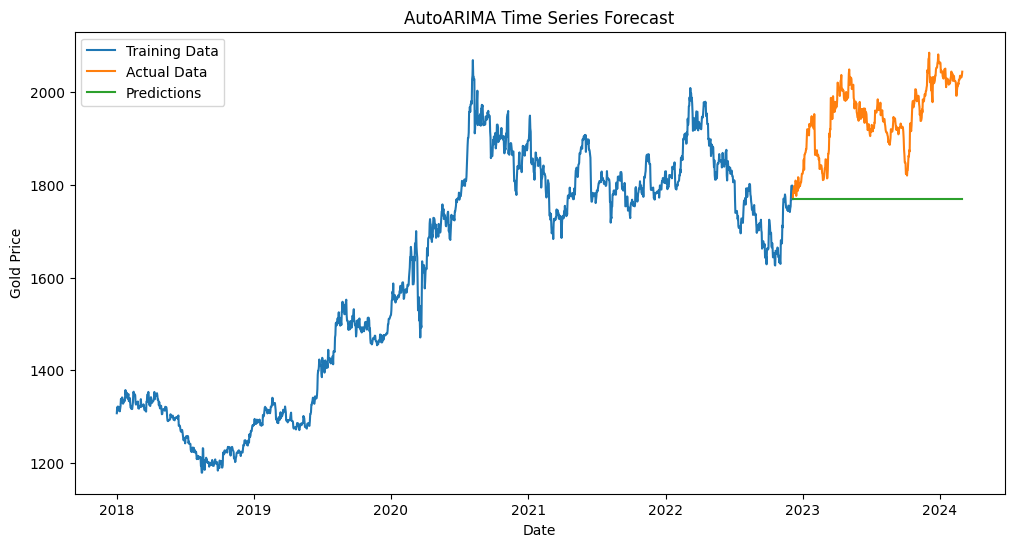

In [ ]:
from pmdarima import auto_arima

# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = auto_arima(g_train_data_8, start_p=0, start_q=0,
                   max_p=5, max_q=5, seasonal=False,
                   d=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit mô hình với các tham số tốt nhất được tìm kiếm
model.fit(g_train_data_8)

# Dự đoán trên tập kiểm tra
g_predictions_2 = model.predict(n_periods=len(g_test_data_2))

# Trực quan hóa kết quả
plt.figure(figsize=(12, 6))
plt.plot(g_train_data_8.index, g_train_data_8, label='Training Data')
plt.plot(g_test_data_2.index, g_test_data_2, label='Actual Data')
plt.plot(g_test_data_2.index, g_predictions_2, label='Predictions')
plt.title('AutoARIMA Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()

##### Đánh giá mô hình

In [ ]:
rmse = calculate_rmse(g_test_data_2, g_predictions_2)
mape = calculate_mape(g_test_data_2, g_predictions_2)
mae = calculate_mae(g_test_data_2, g_predictions_2)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 192.4991259250007
MAPE: 9.036731770858369%
MAE: 178.49978126769898


#### 1.3 Tỉ lệ train, 7:3

##### Kiểm tra tính dừng của dữ liệu

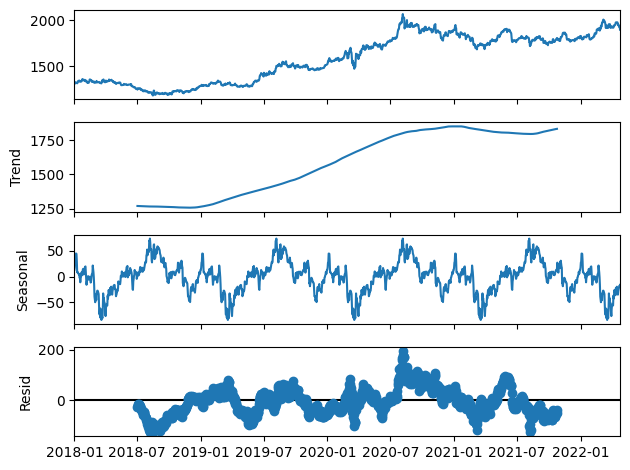

In [ ]:
# kiểm tra dữ liệu có bị tính mùa vụ hay không
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(g_train_data_7, model = 'additive', period=365)
fig = decomposition.plot()
plt.show()

In [ ]:
# Thực hiện kiểm định dickey-fuller trên tập dữ liệu huấn luyện
adftest = adfuller(g_train_data_7)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest[1])

if(adftest[1] < 0.05):
  print("=> Dữ liệu giá vàng dừng")
else:
  print("=> Dữ liệu giá vàng không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  0.8555809832703121
=> Dữ liệu giá vàng không dừng


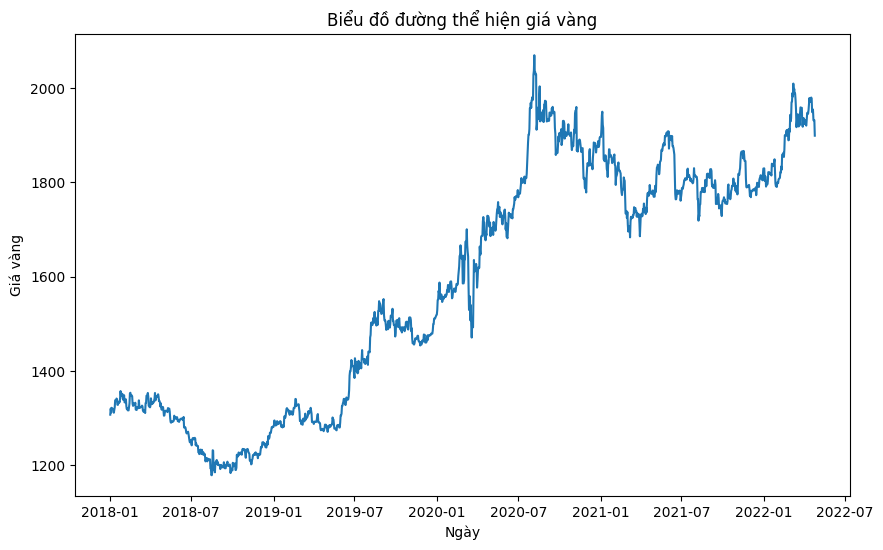

In [ ]:
# Biểu đồ dữ liệu giá vàng ban đầu
plt.figure(figsize=(10, 6))
plt.plot(g_train_data_7.index, g_train_data_7['Train Price'])
plt.title('Biểu đồ đường thể hiện giá vàng')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.show()

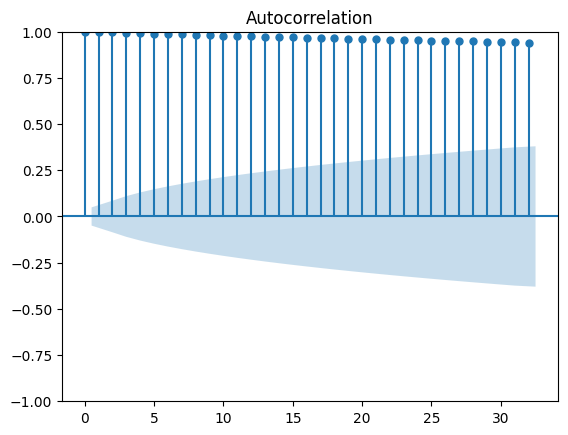

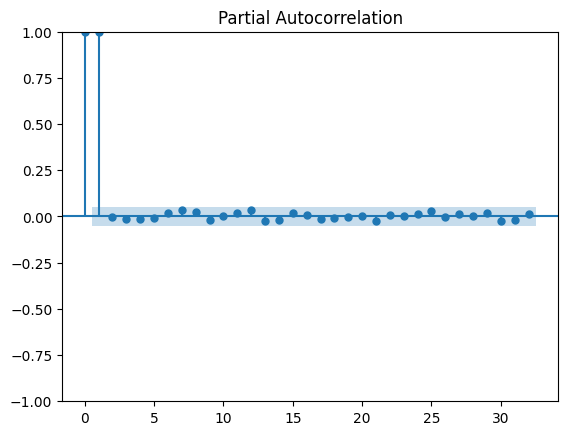

In [ ]:
# Đồ thị acf
origin_acf = plot_acf(g_train_data_7)
# Đồ thị pacf
origin_pacf = plot_pacf(g_train_data_7)

##### Lấy sai phân lần 1

<Axes: xlabel='Date'>

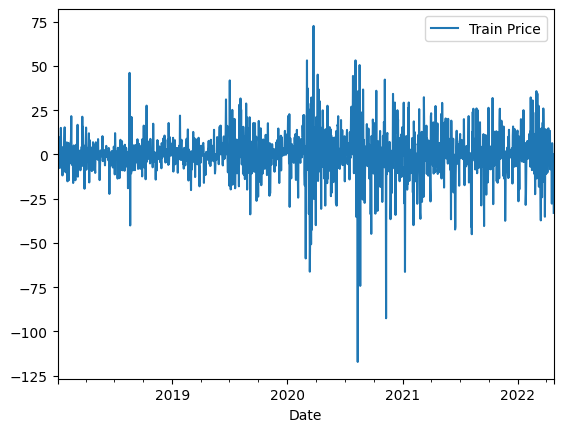

In [ ]:
# Vẽ biểu đồ sau khi lấy sai phân
first_diff = g_train_data_7.diff().dropna()
first_diff.plot()

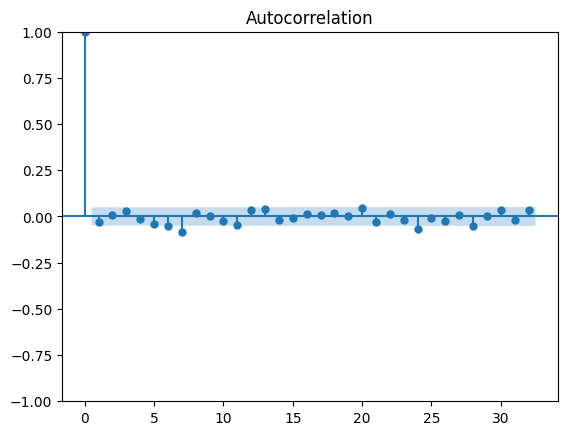

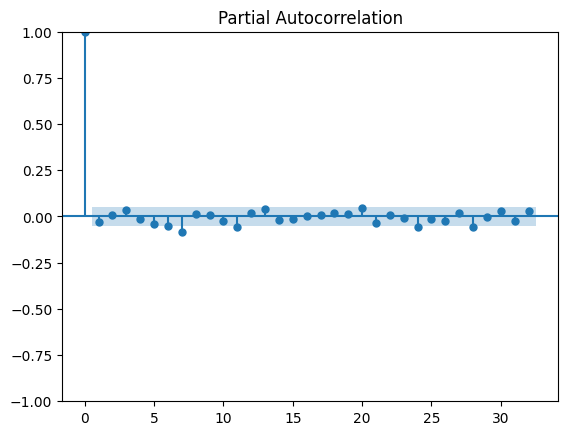

In [ ]:
first_acf = plot_acf(first_diff)
first_pacf = plot_pacf(first_diff)

In [ ]:
# Thực hiện kiểm định dickey-fuller
adftest_1 = adfuller(first_diff)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest_1[1])

if(adftest_1[1] < 0.05):
  print("=> Dữ liệu giá vàng dừng")
else:
  print("=> Dữ liệu giá vàng không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  5.099061475033006e-30
=> Dữ liệu giá vàng dừng


##### **Vì ở trên ta thực hiện kiểm định Dickey Fuller sau lần sai phân thứ 1 đã đạt được chuỗi dừng nên chọn d = 1**

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12503.929, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12504.636, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12504.663, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12503.286, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12506.592, Time=2.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.098 seconds


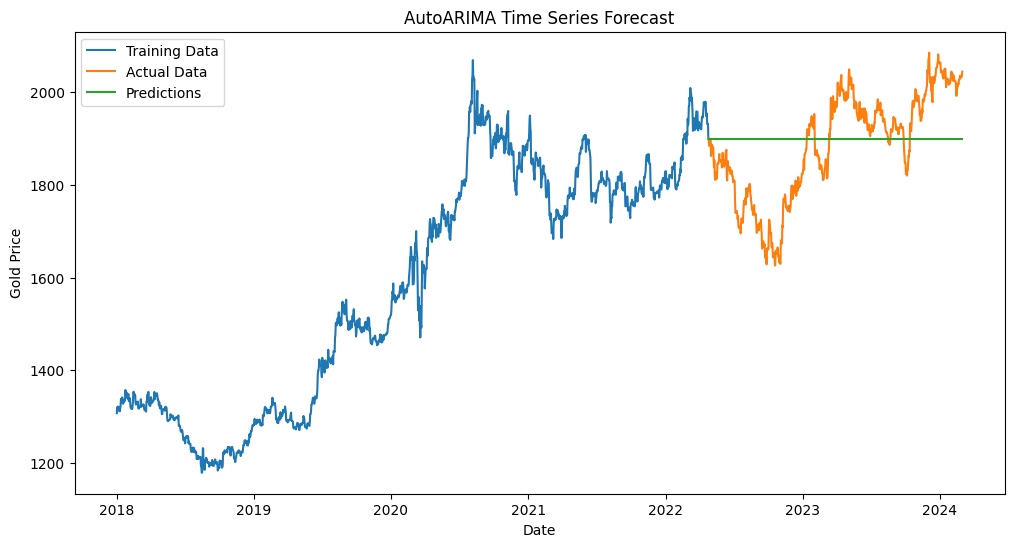

In [ ]:
from pmdarima import auto_arima

# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = auto_arima(g_train_data_7, start_p=0, start_q=0,
                   max_p=5, max_q=5, seasonal=False,
                   d=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit mô hình với các tham số tốt nhất được tìm kiếm
model.fit(g_train_data_7)

# Dự đoán trên tập kiểm tra
g_predictions_3 = model.predict(n_periods=len(g_test_data_3))

# Trực quan hóa kết quả
plt.figure(figsize=(12, 6))
plt.plot(g_train_data_7.index, g_train_data_7, label='Training Data')
plt.plot(g_test_data_3.index, g_test_data_3, label='Actual Data')
plt.plot(g_test_data_3.index, g_predictions_3, label='Predictions')
plt.title('AutoARIMA Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()

##### Đánh giá mô hình

In [ ]:
rmse = calculate_rmse(g_test_data_3, g_predictions_3)
mape = calculate_mape(g_test_data_3, g_predictions_3)
mae = calculate_mae(g_test_data_3, g_predictions_3)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 116.18927118036332
MAPE: 5.293698948649831%
MAE: 97.36475626183433


### 2.Áp dụng mô hình để dự đoán cho dữ liệu về giá bạc

In [ ]:
# Tải dữ liệu từ dataset
df_silver = pd.read_csv('/content/sample_data/silver_price_2018_2024.csv')

df_silver.index += 1

In [ ]:
df_silver.head()

,Date,Value (USD per troy ounce)
1,2018-01-01,16.993771
2,2018-01-02,17.196475
3,2018-01-03,17.112426
4,2018-01-04,17.200338
5,2018-01-05,17.220985


In [ ]:
# Chuyển đổi kiểu dữ liệu
df_silver['Date'] = pd.to_datetime(df_silver['Date'])

# Xoá dữ liệu bị null
df_silver = df_silver.dropna()

# Gán lại tên cột cho dữ liệu
df_silver.columns = ['Date', 'Price']

df_silver.set_index('Date', inplace=True)

df_silver

,Price
Date,
2018-01-01,16.993771
2018-01-02,17.196475
2018-01-03,17.112426
2018-01-04,17.200338
2018-01-05,17.220985
...,...
2024-02-26,22.800718
2024-02-27,22.558054
2024-02-28,22.486938


In [ ]:
# Chia tập dữ liệu huấn luyện, kiểm tra
# Dữ liệu huấn luyến
s_train_data_9 = df_silver[:2026]
s_train_data_8 = df_silver[:1800]
s_train_data_7 = df_silver[:1576]
s_train_data_9.columns = ['Train Price']
s_train_data_8.columns = ['Train Price']
s_train_data_7.columns = ['Train Price']

# Dữ liệu kiểm tra
s_test_data_1 = df_silver[2026:]
s_test_data_2 = df_silver[1800:]
s_test_data_3 = df_silver[1576:]
s_test_data_1.columns = ['Actual Price']
s_test_data_2.columns = ['Actual Price']
s_test_data_3.columns = ['Actual Price']

#### Tỉ lệ dữ liệu 9 : 1

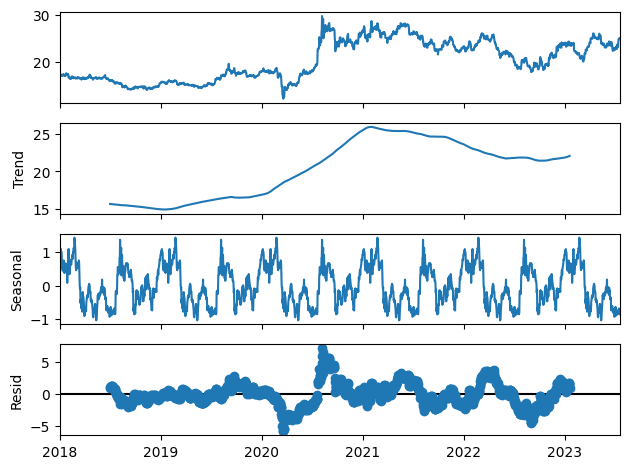

In [ ]:
# xem xét tính mùa vụ của dữ liệu
decomposition = sm.tsa.seasonal_decompose(s_train_data_9, model = 'additive', period=365)
fig = decomposition.plot()
plt.show()

In [ ]:
# Thực hiện kiểm định dickey-fuller trên tập dữ liệu huấn luyện
adftest = adfuller(s_train_data_9)
print('Giá trị p-value cho tập dữ liệu giá bạc là: ', adftest[1])

if(adftest[1] < 0.05):
  print("=> Dữ liệu giá bạc dừng")
else:
  print("=> Dữ liệu giá bạc không dừng")

Giá trị p-value cho tập dữ liệu giá bạc là:  0.45373252627709704
=> Dữ liệu giá bạc không dừng


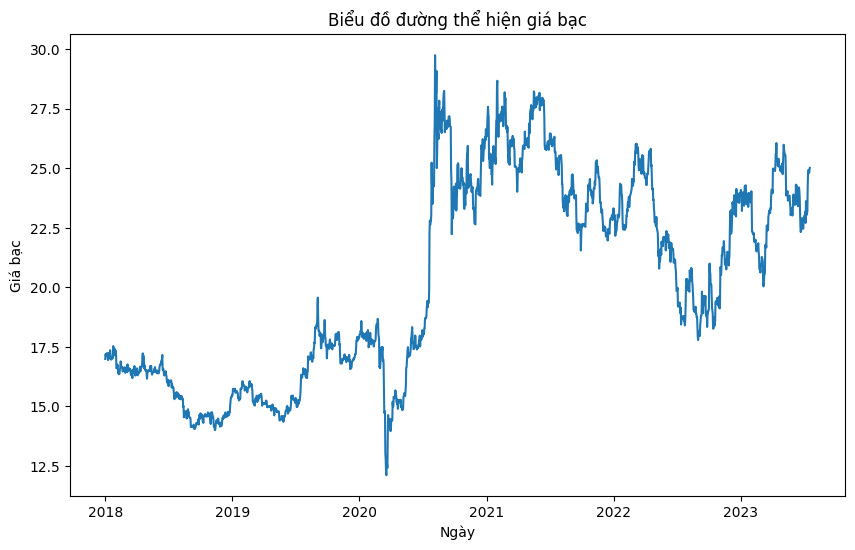

In [ ]:
# Biểu đồ dữ liệu giá bạc ban đầu
plt.figure(figsize=(10, 6))
plt.plot(s_train_data_9.index, s_train_data_9['Train Price'])
plt.title('Biểu đồ đường thể hiện giá bạc')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.show()

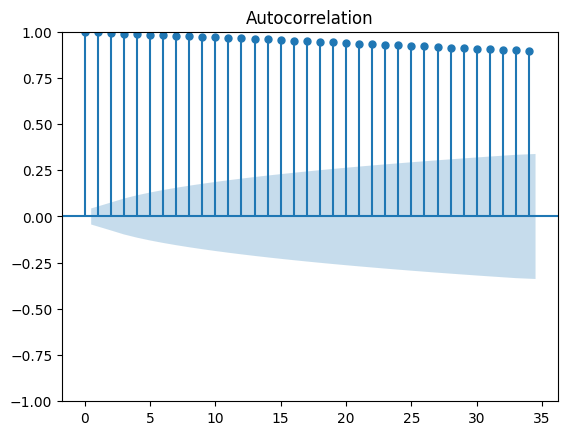

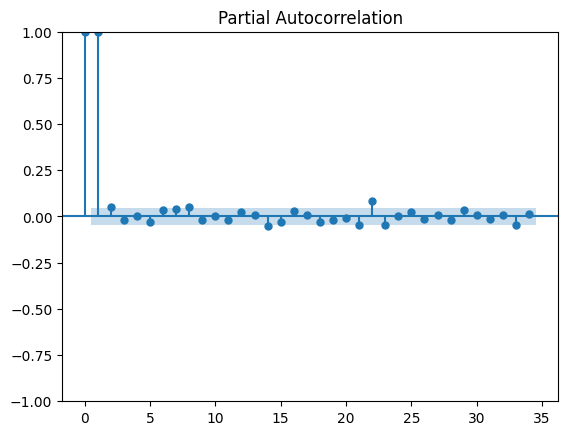

In [ ]:
# Đồ thị acf và pacf
origin_acf = plot_acf(s_train_data_9)
origin_pacf = plot_pacf(s_train_data_9)

In [ ]:
# Thực hiện kiểm định dickey-fuller cho dữ liệu giá bạc sau sai phân lần 1
adftest_1 = adfuller(s_train_data_9)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest_1[1])

if(adftest_1[1] < 0.05):
  print("=> Dữ liệu giá bạch kim dừng")
else:
  print("=> Dữ liệu giá bạch kim không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  0.45373252627709704
=> Dữ liệu giá bạch kim không dừng


<Axes: xlabel='Date'>

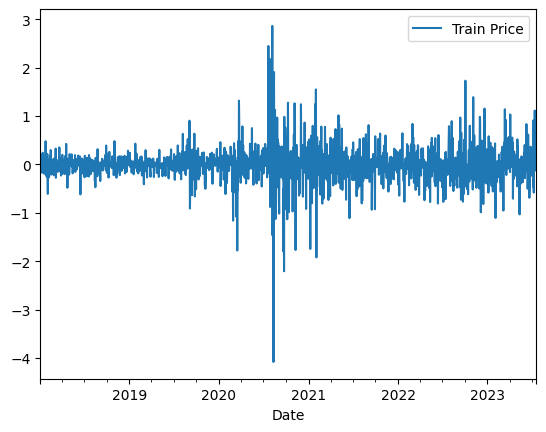

In [ ]:
# Biểu đồ dữ liệu sau khi lấy sai phân lần 1
first_diff = s_train_data_9.diff().dropna()
first_diff.plot()

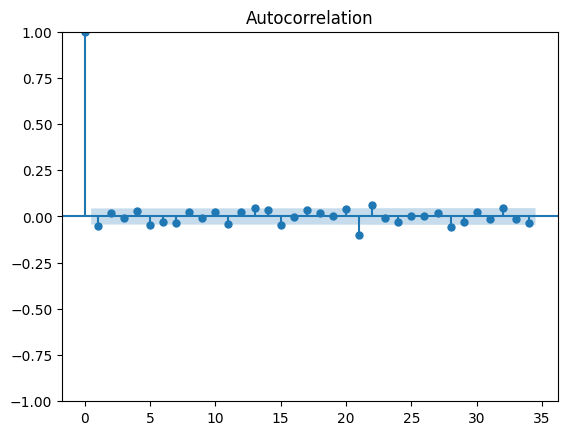

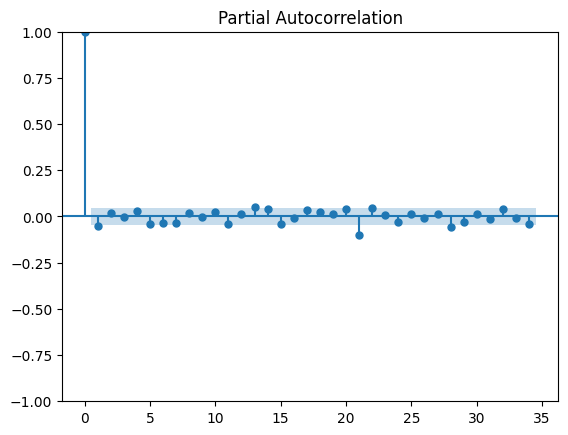

In [ ]:
first_diff_acf = plot_acf(first_diff)
first_diff_pacf = plot_pacf(first_diff)

In [ ]:
# Thực hiện kiểm định dickey-fuller cho dữ liệu giá bạc sau sai phân lần 1
adftest_1 = adfuller(first_diff)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest_1[1])

if(adftest_1[1] < 0.05):
  print("=> Dữ liệu giá bạc dừng")
else:
  print("=> Dữ liệu giá bạc không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  6.541049553536077e-15
=> Dữ liệu giá bạc dừng


##### Vì dữ liệu giá bạc sau khi lấy sai phân lần 1 đã dừng vì vậy chúng ta chọn giá trị sai phân là d = 1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1322.605, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1318.652, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1318.877, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1320.888, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1319.965, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1315.341, Time=1.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1315.943, Time=2.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1315.933, Time=4.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1320.031, Time=0.63 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1318.639, Time=2.88 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1313.634, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1317.192, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1316.966, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1314.251, Time=0.89 sec
 ARIMA(1,1,2)(0,0,0)[0]          

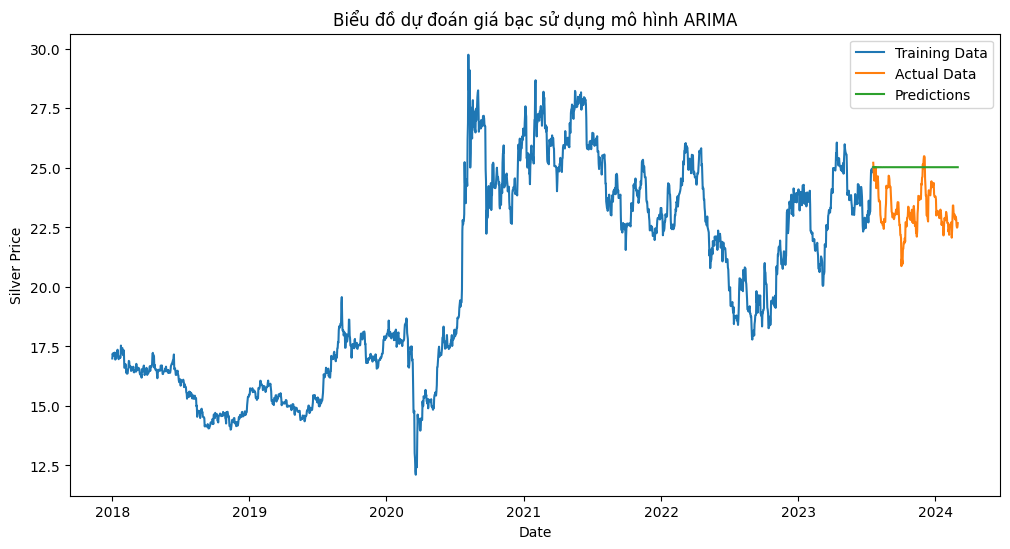

In [ ]:
# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = auto_arima(s_train_data_9, start_p=0, start_q=0,
                   max_p=5, max_q=5, seasonal=False,
                   d=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit mô hình với các tham số tốt nhất được tìm kiếm
model.fit(s_train_data_9)

# Dự đoán trên tập kiểm tra
s_predictions_1 = model.predict(n_periods=len(s_test_data_1))

# Trực quan hóa kết quả
plt.figure(figsize=(12, 6))
plt.plot(s_train_data_9.index, s_train_data_9, label='Training Data')
plt.plot(s_test_data_1.index, s_test_data_1, label='Actual Data')
plt.plot(s_test_data_1.index, s_predictions_1, label='Predictions')
plt.title('Biểu đồ dự đoán giá bạc sử dụng mô hình ARIMA')
plt.xlabel('Date')
plt.ylabel('Silver Price')
plt.legend()
plt.show()

##### Đánh giá mô hình

In [ ]:
# Đánh giá mô hình
mape = calculate_mape(s_test_data_1, s_predictions_1)
rmse = calculate_rmse(s_test_data_1, s_predictions_1)
mae = calculate_mae(s_test_data_1, s_predictions_1)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 1.9590932175405888
MAPE: 7.809798943783959%
MAE: 1.7849533392950578


#### Tỉ lệ dữ liệu 8 : 2

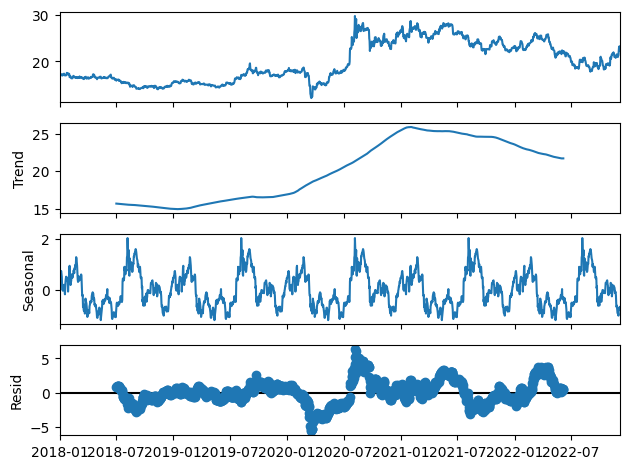

In [ ]:
# xem xét tính mùa vụ của dữ liệu
decomposition = sm.tsa.seasonal_decompose(s_train_data_8, model = 'additive', period=365)
fig = decomposition.plot()
plt.show()

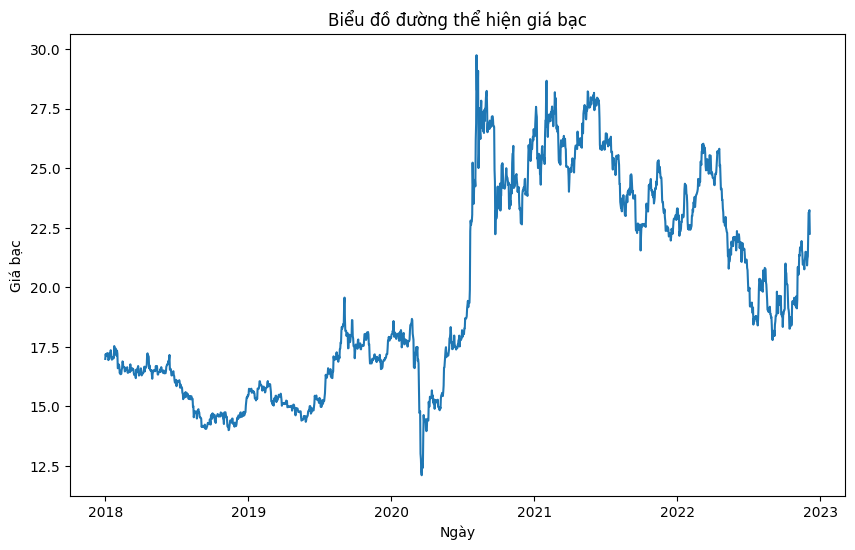

In [ ]:
# Biểu đồ dữ liệu giá bạc ban đầu
plt.figure(figsize=(10, 6))
plt.plot(s_train_data_8.index, s_train_data_8['Train Price'])
plt.title('Biểu đồ đường thể hiện giá bạc')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.show()

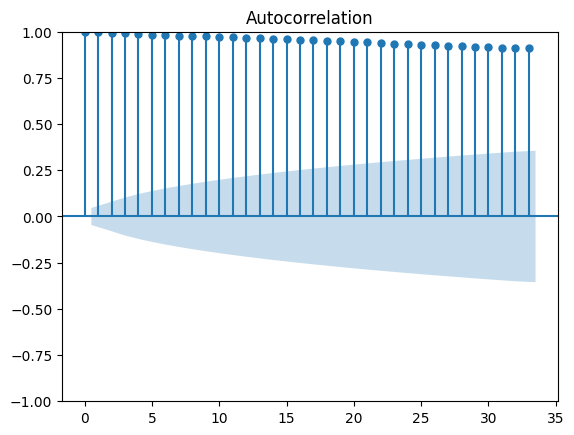

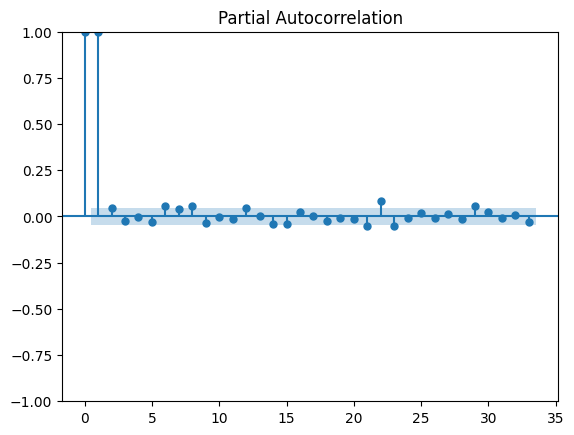

In [ ]:
# Đồ thị acf và pacf
origin_acf = plot_acf(s_train_data_8)
origin_pacf = plot_pacf(s_train_data_8)

In [ ]:
# Thực hiện kiểm định dickey-fuller cho dữ liệu giá bạc sau sai phân lần 1
adftest_1 = adfuller(s_train_data_8)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest_1[1])

if(adftest_1[1] < 0.05):
  print("=> Dữ liệu giá bạch kim dừng")
else:
  print("=> Dữ liệu giá bạch kim không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  0.4745601650023446
=> Dữ liệu giá bạch kim không dừng


<Axes: xlabel='Date'>

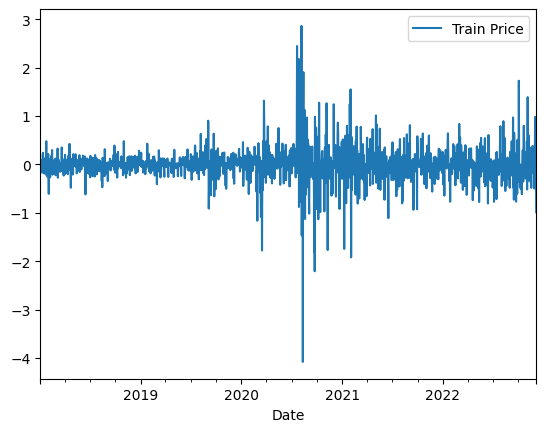

In [ ]:
# Biểu đồ dữ liệu sau khi lấy sai phân lần 1
first_diff = s_train_data_8.diff().dropna()
first_diff.plot()

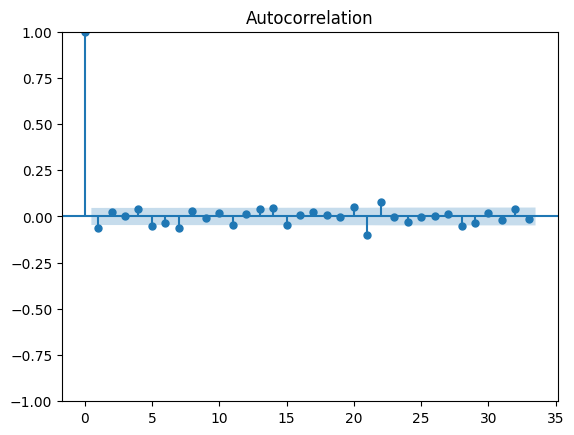

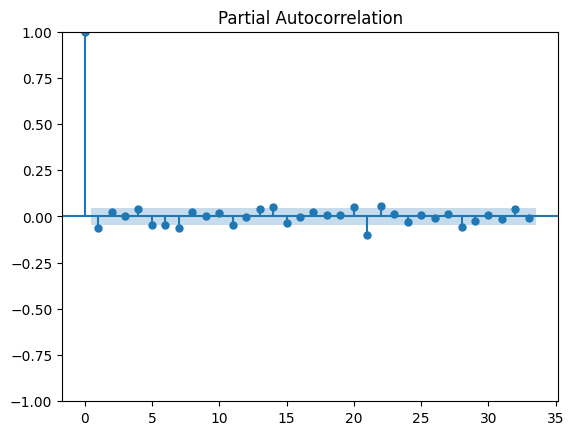

In [ ]:
first_diff_acf = plot_acf(first_diff)
first_diff_pacf = plot_pacf(first_diff)

In [ ]:
# Thực hiện kiểm định dickey-fuller cho dữ liệu giá bạc sau sai phân lần 1
adftest_1 = adfuller(first_diff)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest_1[1])

if(adftest_1[1] < 0.05):
  print("=> Dữ liệu giá bạc dừng")
else:
  print("=> Dữ liệu giá bạc không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  9.3941222690525e-14
=> Dữ liệu giá bạc dừng


##### Vì dữ liệu giá bạc sau khi lấy sai phân lần 1 đã dừng vì vậy chúng ta chọn giá trị sai phân là d = 1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1186.256, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1181.769, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1182.069, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1184.392, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1182.886, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1176.867, Time=1.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1184.733, Time=1.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1177.491, Time=1.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1182.895, Time=0.58 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1180.068, Time=1.64 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1175.009, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1180.225, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1179.925, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1182.878, Time=1.91 sec
 ARIMA(1,1,2)(0,0,0)[0]          

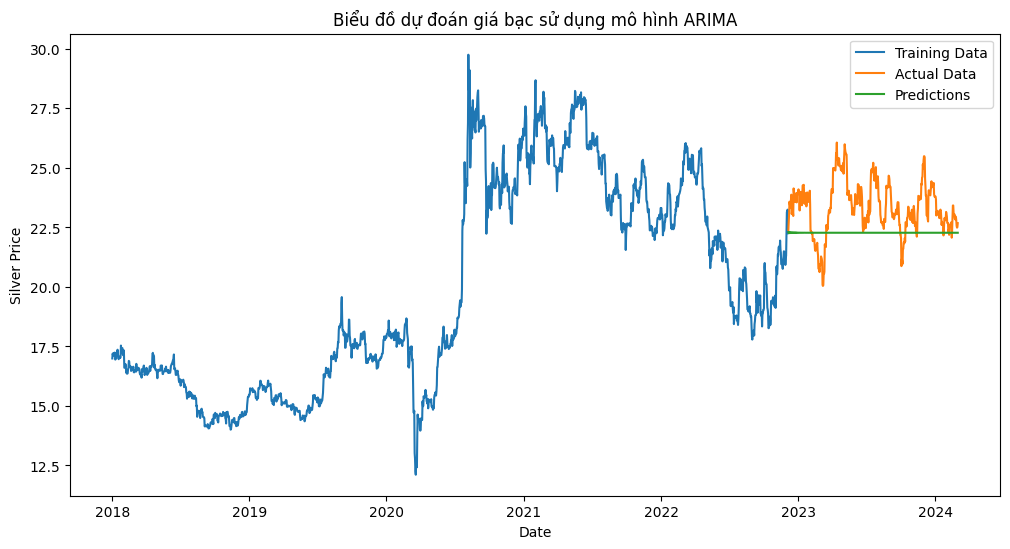

In [ ]:
# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = auto_arima(s_train_data_8, start_p=0, start_q=0,
                   max_p=5, max_q=5, seasonal=False,
                   d=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit mô hình với các tham số tốt nhất được tìm kiếm
model.fit(s_train_data_8)

# Dự đoán trên tập kiểm tra
s_predictions_2 = model.predict(n_periods=len(s_test_data_2))

# Trực quan hóa kết quả
plt.figure(figsize=(12, 6))
plt.plot(s_train_data_8.index, s_train_data_8, label='Training Data')
plt.plot(s_test_data_2.index, s_test_data_2, label='Actual Data')
plt.plot(s_test_data_2.index, s_predictions_2, label='Predictions')
plt.title('Biểu đồ dự đoán giá bạc sử dụng mô hình ARIMA')
plt.xlabel('Date')
plt.ylabel('Silver Price')
plt.legend()
plt.show()

##### Đánh giá mô hình

In [ ]:
# Đánh giá mô hình
mape = calculate_mape(s_test_data_2, s_predictions_2)
rmse = calculate_rmse(s_test_data_2, s_predictions_2)
mae = calculate_mae(s_test_data_2, s_predictions_2)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 1.529491534814337
MAPE: 5.366887708275866%
MAE: 1.2795174149397741


#### Tỉ lệ dữ liệu 7 : 3

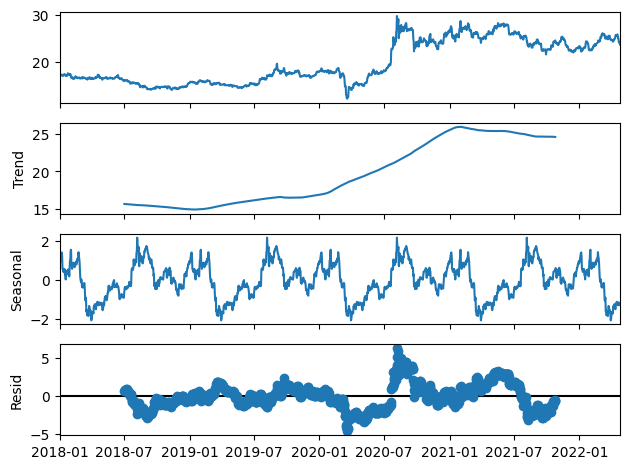

In [ ]:
# xem xét tính mùa vụ của dữ liệu
decomposition = sm.tsa.seasonal_decompose(s_train_data_7, model = 'additive', period=365)
fig = decomposition.plot()
plt.show()

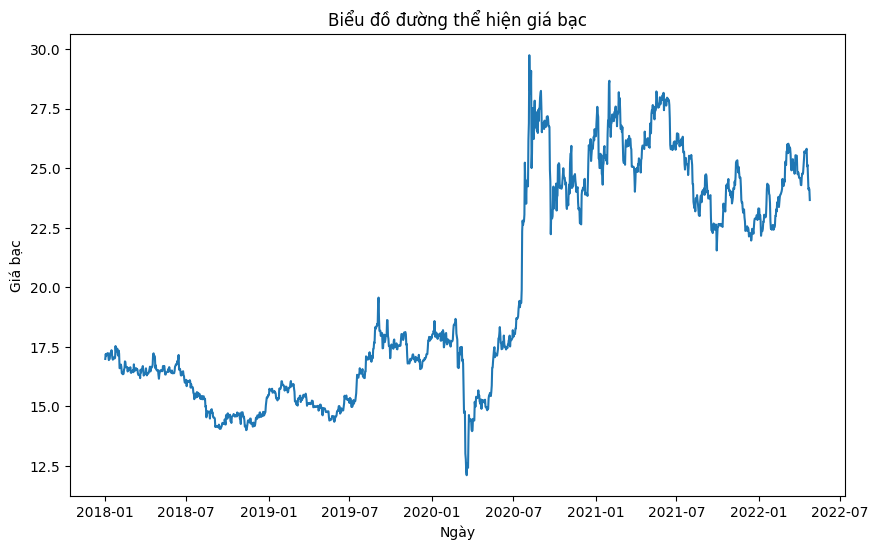

In [ ]:
# Biểu đồ dữ liệu giá bạc ban đầu
plt.figure(figsize=(10, 6))
plt.plot(s_train_data_7.index, s_train_data_7['Train Price'])
plt.title('Biểu đồ đường thể hiện giá bạc')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.show()

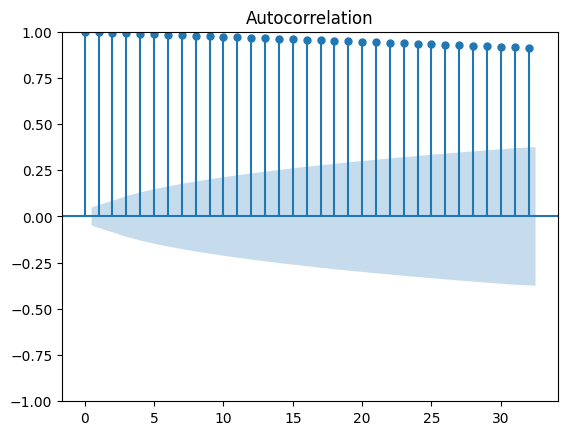

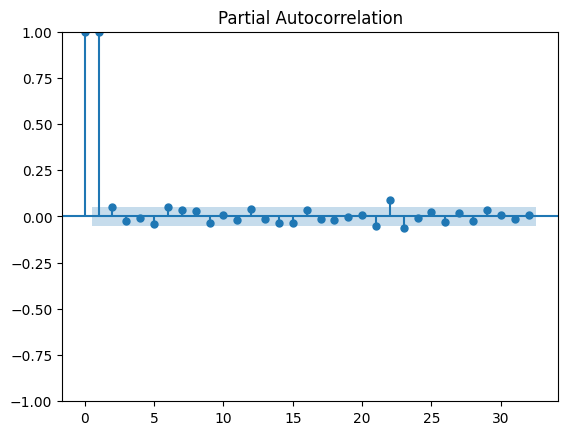

In [ ]:
# Đồ thị acf và pacf
origin_acf = plot_acf(s_train_data_7)
origin_pacf = plot_pacf(s_train_data_7)

In [ ]:
# Thực hiện kiểm định dickey-fuller cho dữ liệu giá bạc sau sai phân lần 1
adftest_1 = adfuller(s_train_data_7)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest_1[1])

if(adftest_1[1] < 0.05):
  print("=> Dữ liệu giá bạch kim dừng")
else:
  print("=> Dữ liệu giá bạch kim không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  0.6264380384396183
=> Dữ liệu giá bạch kim không dừng


<Axes: xlabel='Date'>

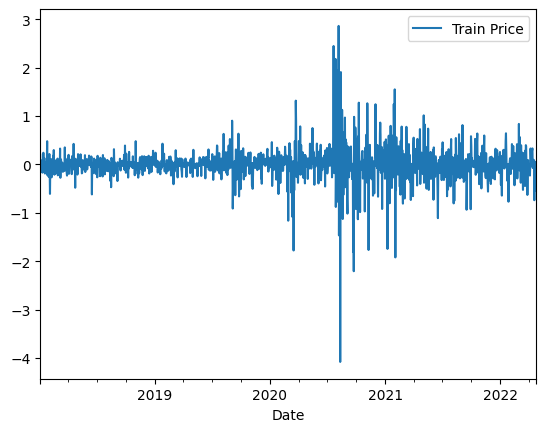

In [ ]:
# Biểu đồ dữ liệu sau khi lấy sai phân lần 1
first_diff = s_train_data_7.diff().dropna()
first_diff.plot()

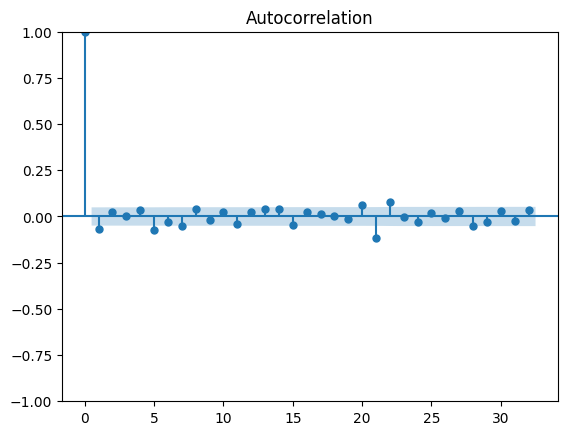

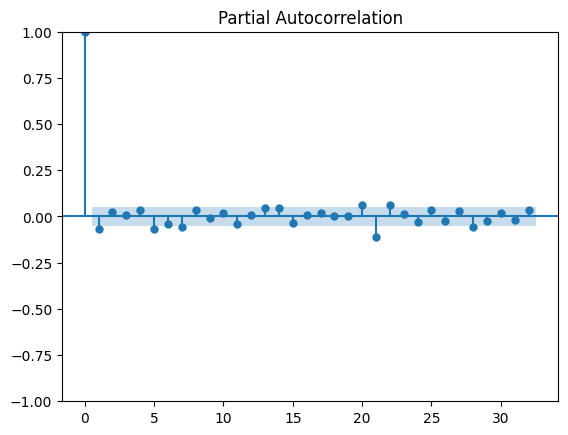

In [ ]:
first_diff_acf = plot_acf(first_diff)
first_diff_pacf = plot_pacf(first_diff)

In [ ]:
# Thực hiện kiểm định dickey-fuller cho dữ liệu giá bạc sau sai phân lần 1
adftest_1 = adfuller(first_diff)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest_1[1])

if(adftest_1[1] < 0.05):
  print("=> Dữ liệu giá bạc dừng")
else:
  print("=> Dữ liệu giá bạc không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  2.407547118923315e-12
=> Dữ liệu giá bạc dừng


##### Vì dữ liệu giá bạc sau khi lấy sai phân lần 1 đã dừng vì vậy chúng ta chọn giá trị sai phân là d = 1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1019.274, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1014.212, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1014.543, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1017.527, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1015.463, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1008.789, Time=1.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1017.303, Time=1.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1009.195, Time=3.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1015.411, Time=1.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1011.209, Time=2.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1007.054, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1012.835, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1012.503, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1015.575, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0]          

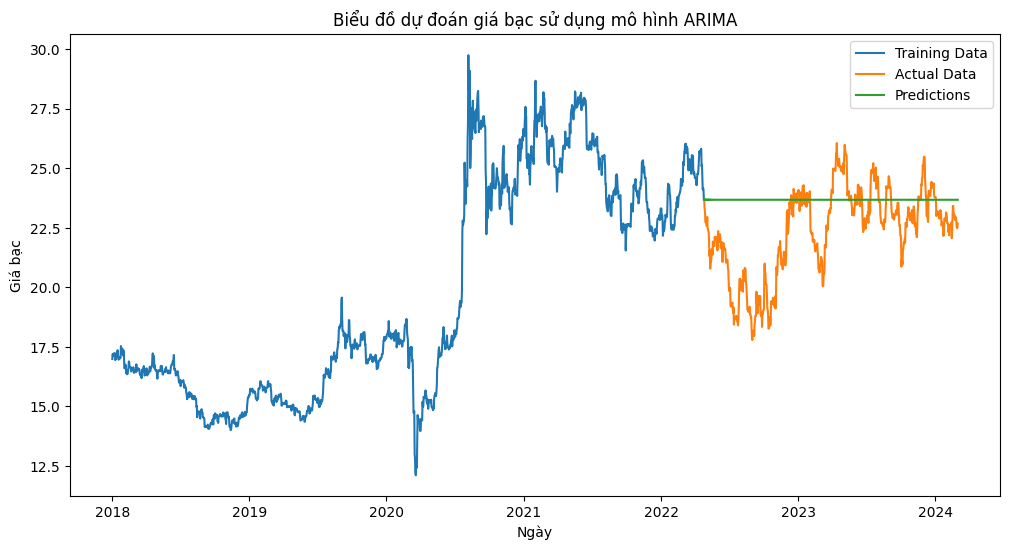

In [ ]:
# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = auto_arima(s_train_data_7, start_p=0, start_q=0,
                   max_p=5, max_q=5, seasonal=False,
                   d=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit mô hình với các tham số tốt nhất được tìm kiếm
model.fit(s_train_data_7)

# Dự đoán trên tập kiểm tra
s_predictions_3 = model.predict(n_periods=len(s_test_data_3))

# Trực quan hóa kết quả
plt.figure(figsize=(12, 6))
plt.plot(s_train_data_7.index, s_train_data_7, label='Training Data')
plt.plot(s_test_data_3.index, s_test_data_3, label='Actual Data')
plt.plot(s_test_data_3.index, s_predictions_3, label='Predictions')
plt.title('Biểu đồ dự đoán giá bạc sử dụng mô hình ARIMA')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.legend()
plt.show()

##### Đánh giá mô hình

In [ ]:
# Đánh giá mô hình
mape = calculate_mape(s_test_data_3, s_predictions_3)
rmse = calculate_rmse(s_test_data_3, s_predictions_3)
mae = calculate_mae(s_test_data_3, s_predictions_3)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 2.2783745932019612
MAPE: 8.21019896002551%
MAE: 1.6996149197945458


### 3.Áp dụng mô hình để dự đoán cho dữ liệu về giá bạch kim

In [ ]:
# Tải dữ liệu từ dataset
df_platium = pd.read_csv('/content/sample_data/platium_price_2018_2024.csv')

df_platium.index += 1

In [ ]:
df_platium.head()

,Date,Value (USD per troy ounce)
1,2018-01-01,930.030587
2,2018-01-02,944.375754
3,2018-01-03,954.910273
4,2018-01-04,960.864535
5,2018-01-05,969.196081


In [ ]:
# Chuyển đổi kiểu dữ liệu
df_platium['Date'] = pd.to_datetime(df_platium['Date'])

# Xoá dữ liệu bị null
df_platium = df_platium.dropna()

# Gán lại tên cột cho dữ liệu
df_platium.columns = ['Date', 'Price']

df_platium.set_index('Date', inplace=True)

df_platium

,Price
Date,
2018-01-01,930.030587
2018-01-02,944.375754
2018-01-03,954.910273
2018-01-04,960.864535
2018-01-05,969.196081
...,...
2024-02-26,899.357490
2024-02-27,884.772925
2024-02-28,893.184032


In [ ]:
# Chia tập dữ liệu huấn luyện, kiểm tra
# Dữ liệu huấn luyện
p_train_data_9 = df_platium[:2026]
p_train_data_8 = df_platium[:1800]
p_train_data_7 = df_platium[:1576]
p_train_data_9.columns = ['Train Price']
p_train_data_8.columns = ['Train Price']
p_train_data_7.columns = ['Train Price']

# Dữ liệu kiểm tra
p_test_data_1 = df_platium[2026:]
p_test_data_2 = df_platium[1800:]
p_test_data_3 = df_platium[1576:]
p_test_data_1.columns = ['Actual Price']
p_test_data_2.columns = ['Actual Price']
p_test_data_3.columns = ['Actual Price']

#### Tỉ lệ dữ liệu 9:1

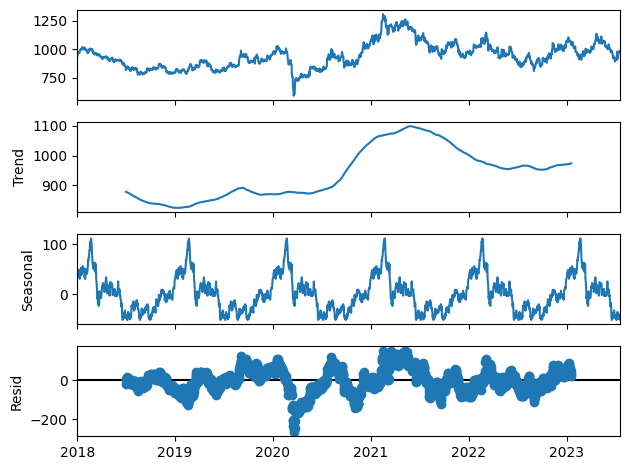

In [ ]:
# Kiểm tra tính mùa vụ của dữ liệu
decomposition = sm.tsa.seasonal_decompose(p_train_data_9, model = 'additive', period=365)
fig = decomposition.plot()
plt.show()

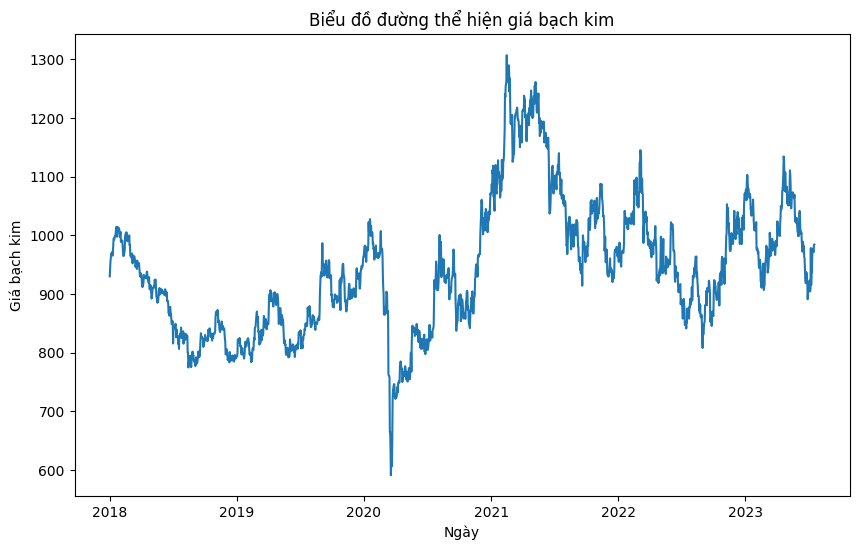

In [ ]:
# Biểu đồ dữ liệu giá bạc ban đầu
plt.figure(figsize=(10, 6))
plt.plot(p_train_data_9.index, p_train_data_9['Train Price'])
plt.title('Biểu đồ đường thể hiện giá bạch kim')
plt.xlabel('Ngày')
plt.ylabel('Giá bạch kim')
plt.show()

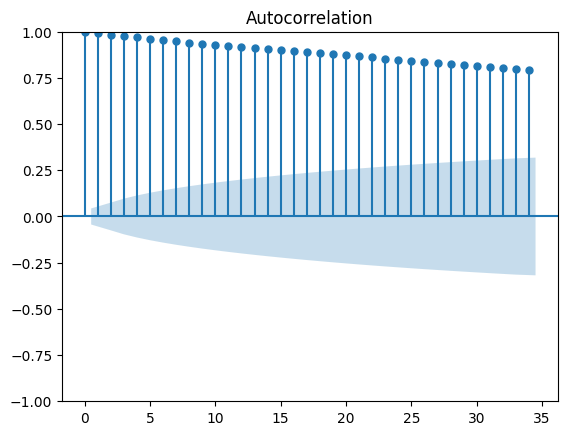

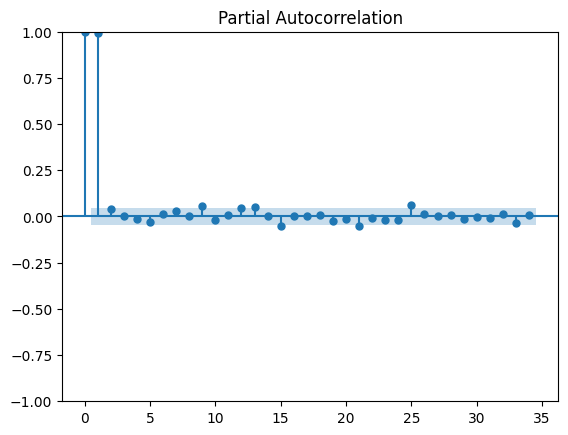

In [ ]:
# Đồ thị acf và pacf
origin_acf = plot_acf(p_train_data_9)
origin_pacf = plot_pacf(p_train_data_9)

In [ ]:
# Thực hiện kiểm định dickey-fuller trên tập dữ liệu huấn luyện
adftest = adfuller(p_train_data_9)
print('Giá trị p-value cho tập dữ liệu giá bạc là: ', adftest[1])

if(adftest[1] < 0.05):
  print("=> Dữ liệu giá bạch kim dừng")
else:
  print("=> Dữ liệu giá bạch kim không dừng")

Giá trị p-value cho tập dữ liệu giá bạc là:  0.13352863812763377
=> Dữ liệu giá bạch kim không dừng


<Axes: xlabel='Date'>

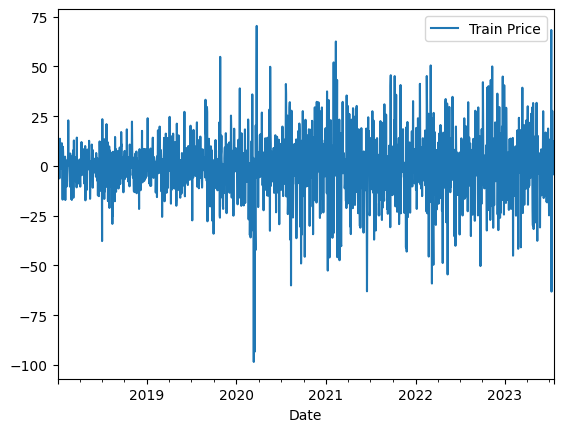

In [ ]:
# Biểu đồ dữ liệu sau khi lấy sai phân lần 1
first_diff = p_train_data_9.diff().dropna()
first_diff.plot()

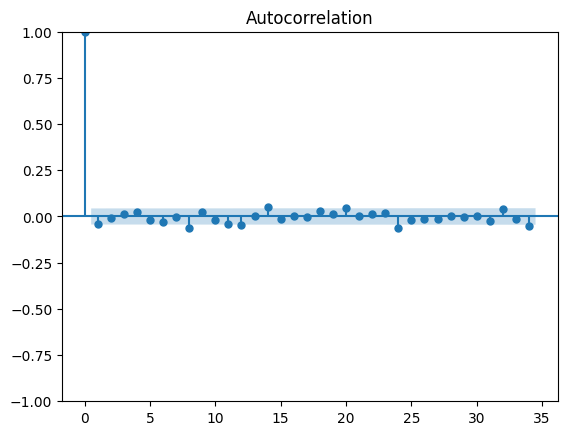

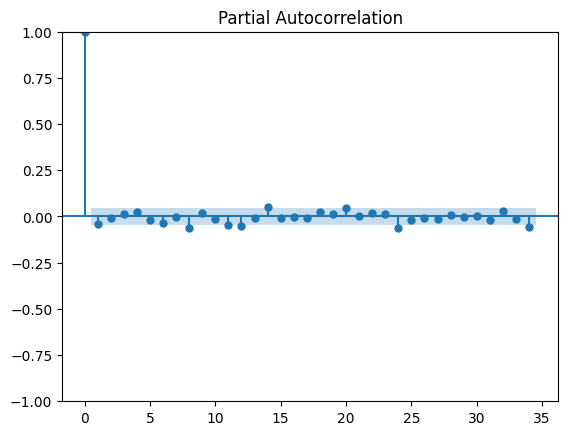

In [ ]:
first_diff_acf = plot_acf(first_diff)
first_diff_pacf = plot_pacf(first_diff)

In [ ]:
# Thực hiện kiểm định dickey-fuller cho dữ liệu giá bạc sau sai phân lần 1
adftest_1 = adfuller(first_diff)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest_1[1])

if(adftest_1[1] < 0.05):
  print("=> Dữ liệu giá bạch kim dừng")
else:
  print("=> Dữ liệu giá bạch kim không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  2.97254640920395e-24
=> Dữ liệu giá bạch kim dừng


##### Vì dữ liệu giá bạch kim sau khi lấy sai phân lần 1 đã dừng vì vậy chúng ta chọn giá trị sai phân là d = 1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16518.444, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16516.661, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16516.615, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16516.451, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16518.592, Time=1.84 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.530 seconds


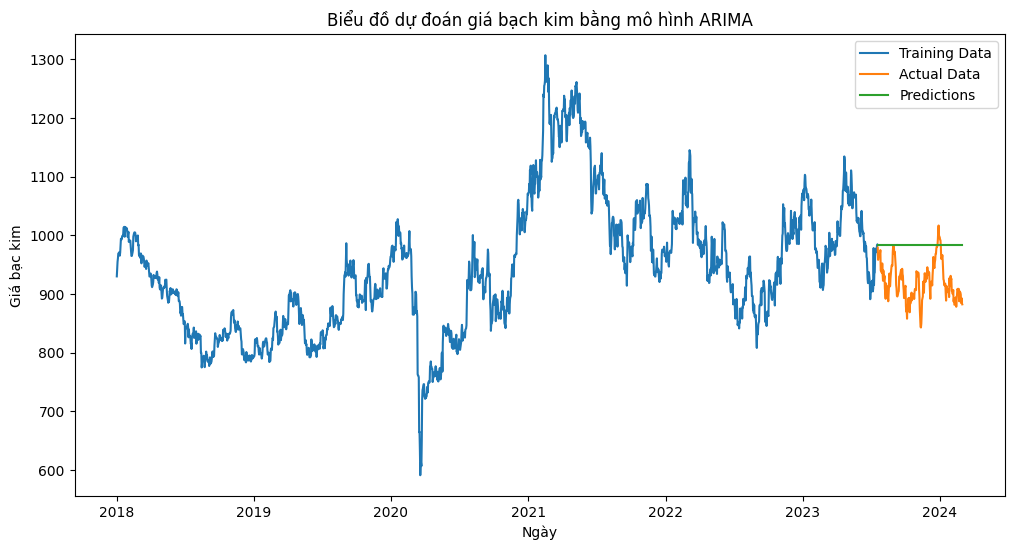

In [ ]:
# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = auto_arima(p_train_data_9, start_p=0, start_q=0,
                   max_p=5, max_q=5, seasonal=False,
                   d=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit mô hình với các tham số tốt nhất được tìm kiếm
model.fit(p_train_data_9)

# Dự đoán trên tập kiểm tra
p_predictions_1 = model.predict(n_periods=len(p_test_data_1))

# Trực quan hóa kết quả
plt.figure(figsize=(12, 6))
plt.plot(p_train_data_9.index, p_train_data_9, label='Training Data')
plt.plot(p_test_data_1.index, p_test_data_1, label='Actual Data')
plt.plot(p_test_data_1.index, p_predictions_1, label='Predictions')
plt.title('Biểu đồ dự đoán giá bạch kim bằng mô hình ARIMA')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc kim')
plt.legend()
plt.show()

##### Đánh giá mô hình

In [ ]:
# Đánh giá mô hình
rmse = calculate_rmse(p_test_data_1, p_predictions_1)
mape = calculate_mape(p_test_data_1, p_predictions_1)
mae = calculate_mae(p_test_data_1, p_predictions_1)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 70.60234316887538
MAPE: 7.043571043343146%
MAE: 63.79692741725664


#### Tỉ lệ dữ liệu 8:2

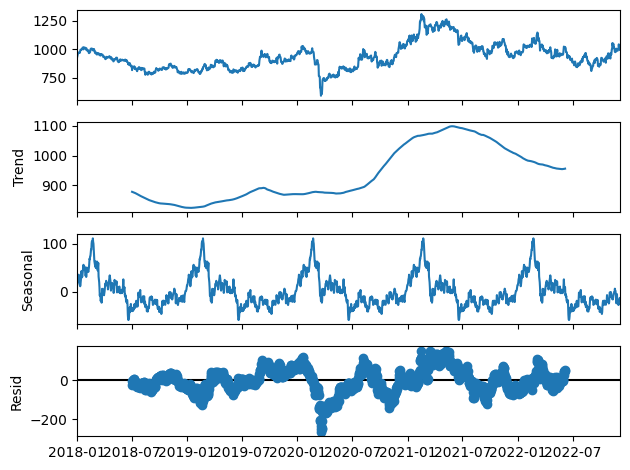

In [ ]:
# Kiểm tra tính mùa vụ của dữ liệu
decomposition = sm.tsa.seasonal_decompose(p_train_data_8, model = 'additive', period=365)
fig = decomposition.plot()
plt.show()

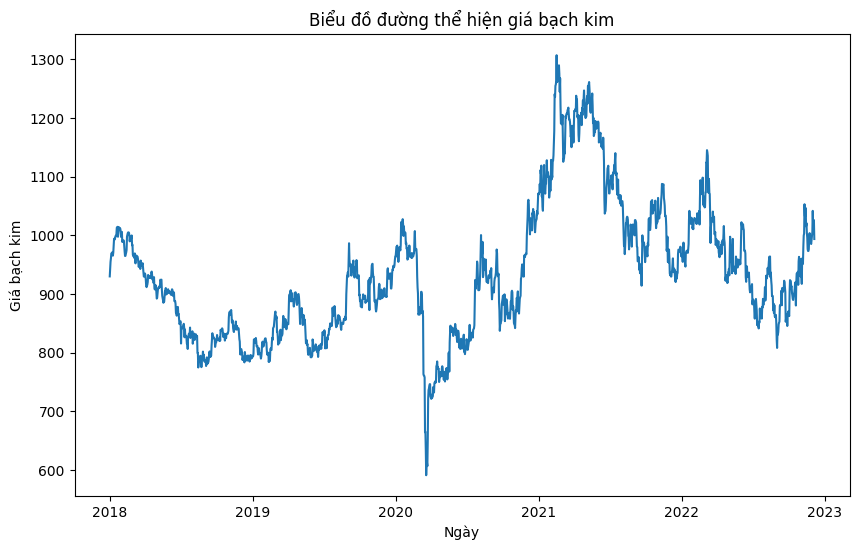

In [ ]:
# Biểu đồ dữ liệu giá bạc ban đầu
plt.figure(figsize=(10, 6))
plt.plot(p_train_data_8.index, p_train_data_8['Train Price'])
plt.title('Biểu đồ đường thể hiện giá bạch kim')
plt.xlabel('Ngày')
plt.ylabel('Giá bạch kim')
plt.show()

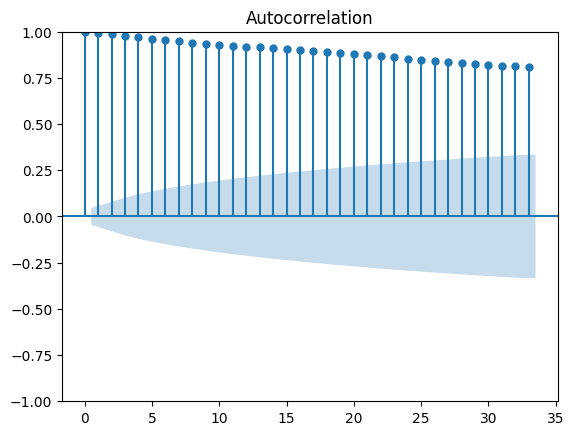

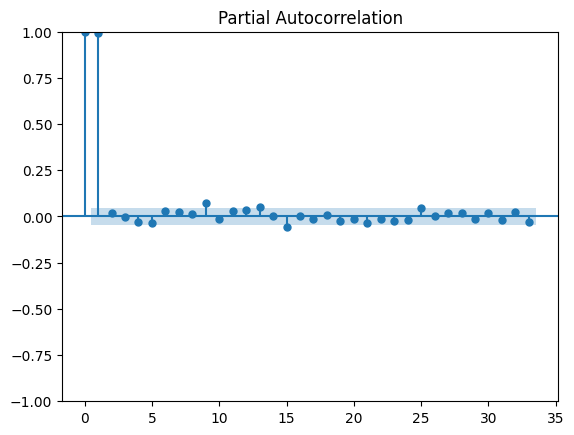

In [ ]:
# Đồ thị acf và pacf
origin_acf = plot_acf(p_train_data_8)
origin_pacf = plot_pacf(p_train_data_8)

In [ ]:
# Thực hiện kiểm định dickey-fuller trên tập dữ liệu huấn luyện
adftest = adfuller(p_train_data_8)
print('Giá trị p-value cho tập dữ liệu giá bạc là: ', adftest[1])

if(adftest[1] < 0.05):
  print("=> Dữ liệu giá bạch kim dừng")
else:
  print("=> Dữ liệu giá bạch kim không dừng")

Giá trị p-value cho tập dữ liệu giá bạc là:  0.21845835571398964
=> Dữ liệu giá bạch kim không dừng


<Axes: xlabel='Date'>

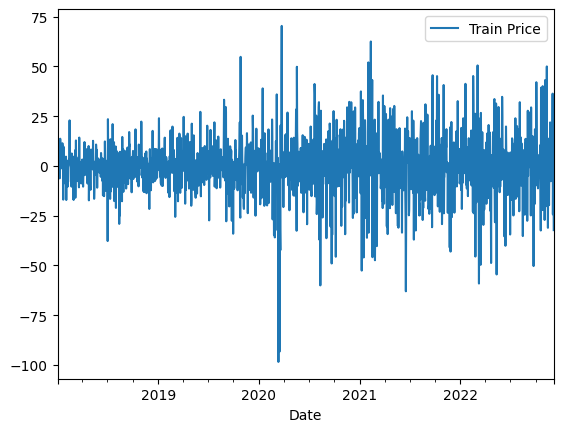

In [ ]:
# Biểu đồ dữ liệu sau khi lấy sai phân lần 1
first_diff = p_train_data_8.diff().dropna()
first_diff.plot()

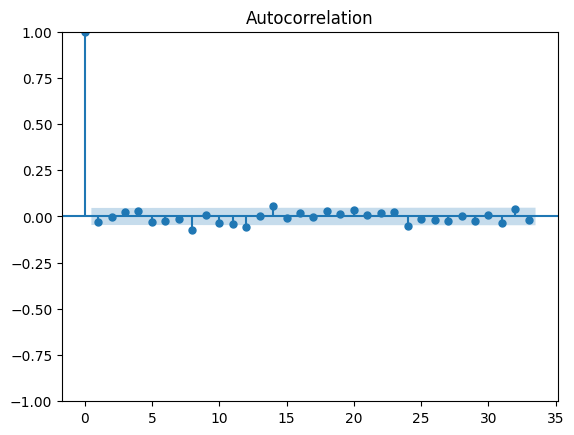

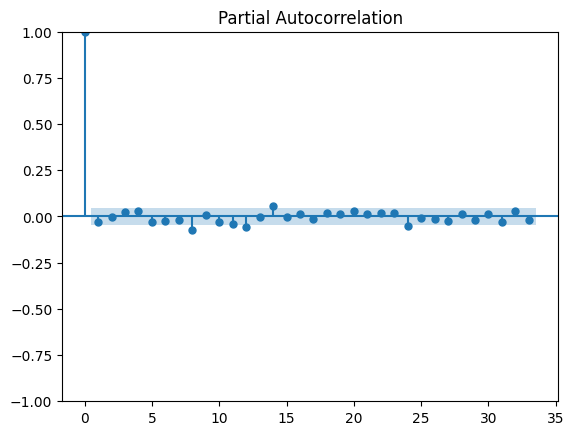

In [ ]:
first_diff_acf = plot_acf(first_diff)
first_diff_pacf = plot_pacf(first_diff)

In [ ]:
# Thực hiện kiểm định dickey-fuller cho dữ liệu giá bạc sau sai phân lần 1
adftest_1 = adfuller(first_diff)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest_1[1])

if(adftest_1[1] < 0.05):
  print("=> Dữ liệu giá bạch kim dừng")
else:
  print("=> Dữ liệu giá bạch kim không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  3.603496973198928e-23
=> Dữ liệu giá bạch kim dừng


##### Vì dữ liệu giá bạch kim sau khi lấy sai phân lần 1 đã dừng vì vậy chúng ta chọn giá trị sai phân là d = 1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14624.105, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14624.556, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14624.555, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14622.116, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14626.554, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.219 seconds


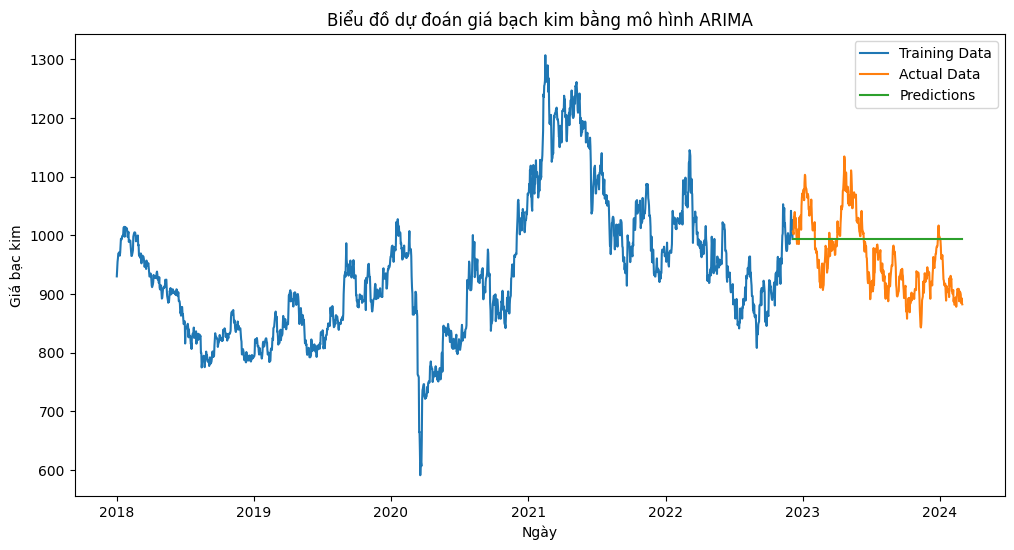

In [ ]:
# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = auto_arima(p_train_data_8, start_p=0, start_q=0,
                   max_p=5, max_q=5, seasonal=False,
                   d=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit mô hình với các tham số tốt nhất được tìm kiếm
model.fit(p_train_data_8)

# Dự đoán trên tập kiểm tra
p_predictions_2 = model.predict(n_periods=len(p_test_data_2))

# Trực quan hóa kết quả
plt.figure(figsize=(12, 6))
plt.plot(p_train_data_8.index, p_train_data_8, label='Training Data')
plt.plot(p_test_data_2.index, p_test_data_2, label='Actual Data')
plt.plot(p_test_data_2.index, p_predictions_2, label='Predictions')
plt.title('Biểu đồ dự đoán giá bạch kim bằng mô hình ARIMA')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc kim')
plt.legend()
plt.show()

##### Đánh giá mô hình

In [ ]:
# Đánh giá mô hình
rmse = calculate_rmse(p_test_data_2, p_predictions_2)
mape = calculate_mape(p_test_data_2, p_predictions_2)
mae = calculate_mae(p_test_data_2, p_predictions_2)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 68.2397891834259
MAPE: 6.248942573050706%
MAE: 59.070146617477846


#### Tỉ lệ dữ liệu 7:3

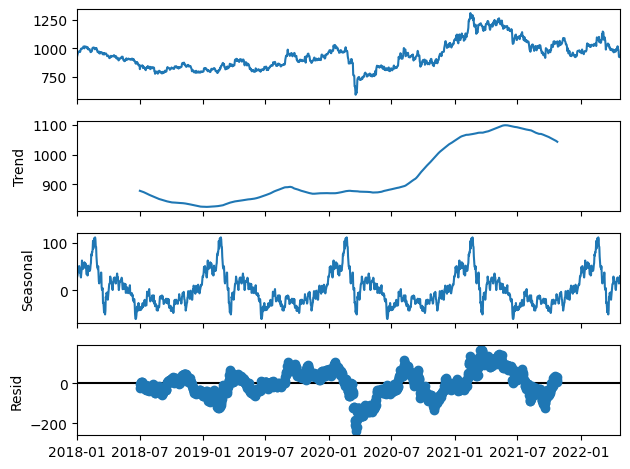

In [ ]:
# Kiểm tra tính mùa vụ của dữ liệu
decomposition = sm.tsa.seasonal_decompose(p_train_data_7, model = 'additive', period=365)
fig = decomposition.plot()
plt.show()

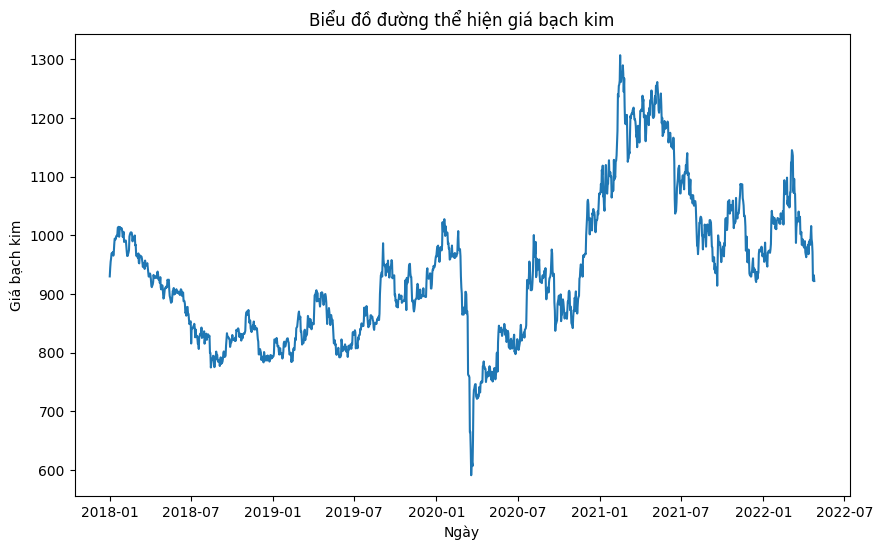

In [ ]:
# Biểu đồ dữ liệu giá bạc ban đầu
plt.figure(figsize=(10, 6))
plt.plot(p_train_data_7.index, p_train_data_7['Train Price'])
plt.title('Biểu đồ đường thể hiện giá bạch kim')
plt.xlabel('Ngày')
plt.ylabel('Giá bạch kim')
plt.show()

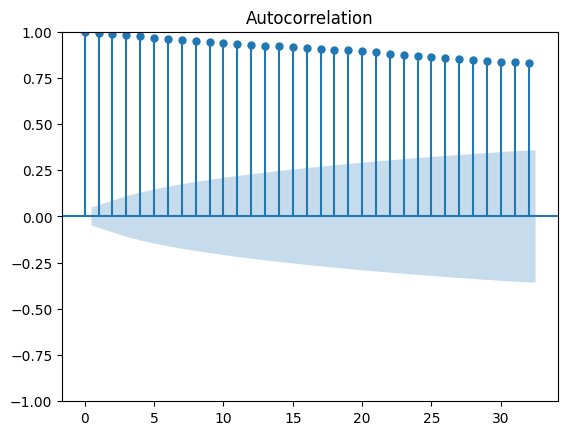

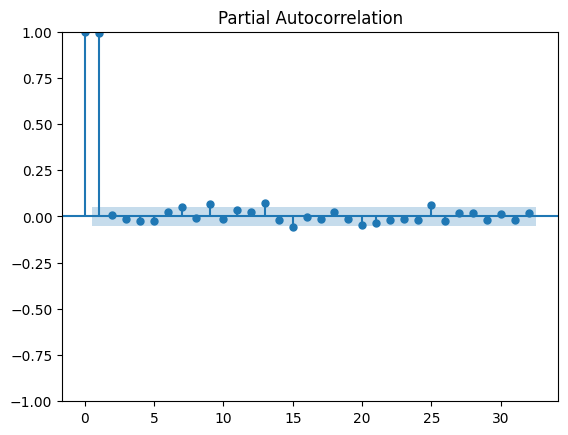

In [ ]:
# Đồ thị acf và pacf
origin_acf = plot_acf(p_train_data_7)
origin_pacf = plot_pacf(p_train_data_7)

In [ ]:
# Thực hiện kiểm định dickey-fuller trên tập dữ liệu huấn luyện
adftest = adfuller(p_train_data_7)
print('Giá trị p-value cho tập dữ liệu giá bạc là: ', adftest[1])

if(adftest[1] < 0.05):
  print("=> Dữ liệu giá bạch kim dừng")
else:
  print("=> Dữ liệu giá bạch kim không dừng")

Giá trị p-value cho tập dữ liệu giá bạc là:  0.2989713052255222
=> Dữ liệu giá bạch kim không dừng


<Axes: xlabel='Date'>

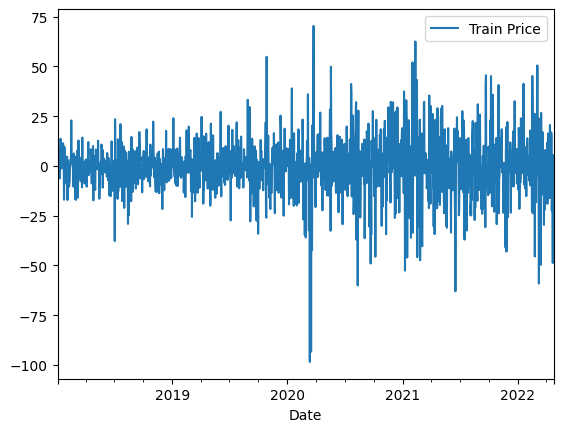

In [ ]:
# Biểu đồ dữ liệu sau khi lấy sai phân lần 1
first_diff = p_train_data_7.diff().dropna()
first_diff.plot()

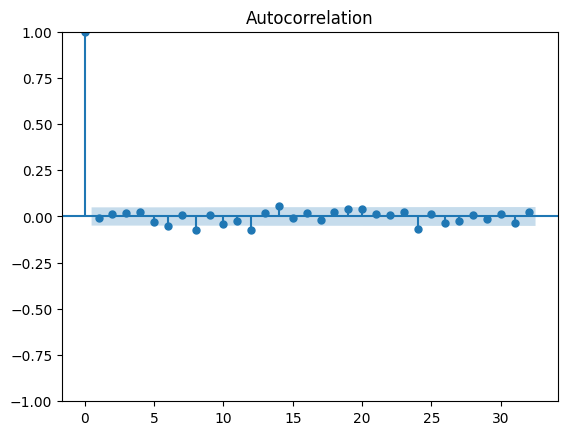

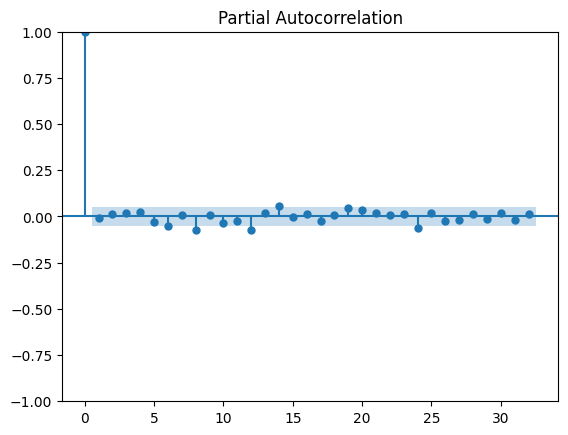

In [ ]:
first_diff_acf = plot_acf(first_diff)
first_diff_pacf = plot_pacf(first_diff)

In [ ]:
# Thực hiện kiểm định dickey-fuller cho dữ liệu giá bạc sau sai phân lần 1
adftest_1 = adfuller(first_diff)
print('Giá trị p-value cho tập dữ liệu giá vàng là: ', adftest_1[1])

if(adftest_1[1] < 0.05):
  print("=> Dữ liệu giá bạch kim dừng")
else:
  print("=> Dữ liệu giá bạch kim không dừng")

Giá trị p-value cho tập dữ liệu giá vàng là:  7.42405625023216e-21
=> Dữ liệu giá bạch kim dừng


##### Vì dữ liệu giá bạch kim sau khi lấy sai phân lần 1 đã dừng vì vậy chúng ta chọn giá trị sai phân là d = 1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12727.622, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12729.526, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12729.528, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12725.622, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12731.619, Time=1.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.149 seconds


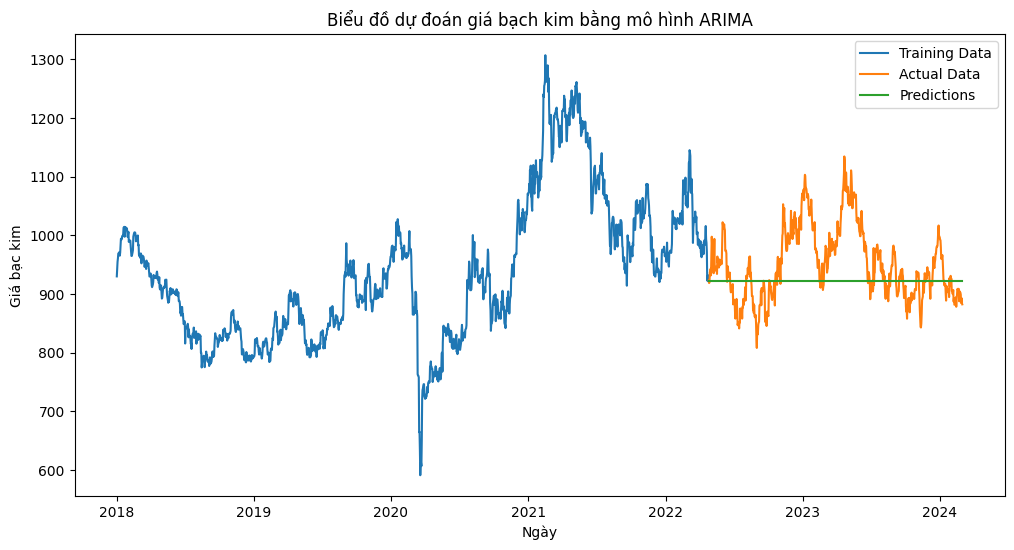

In [ ]:
# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = auto_arima(p_train_data_7, start_p=0, start_q=0,
                   max_p=5, max_q=5, seasonal=False,
                   d=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit mô hình với các tham số tốt nhất được tìm kiếm
model.fit(p_train_data_7)

# Dự đoán trên tập kiểm tra
p_predictions_3 = model.predict(n_periods=len(p_test_data_3))

# Trực quan hóa kết quả
plt.figure(figsize=(12, 6))
plt.plot(p_train_data_7.index, p_train_data_7, label='Training Data')
plt.plot(p_test_data_3.index, p_test_data_3, label='Actual Data')
plt.plot(p_test_data_3.index, p_predictions_3, label='Predictions')
plt.title('Biểu đồ dự đoán giá bạch kim bằng mô hình ARIMA')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc kim')
plt.legend()
plt.show()

##### Đánh giá mô hình

In [ ]:
# Đánh giá mô hình
rmse = calculate_rmse(p_test_data_3, p_predictions_3)
mape = calculate_mape(p_test_data_3, p_predictions_3)
mae = calculate_mae(p_test_data_3, p_predictions_3)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")

RMSE: 67.47102495483884
MAPE: 5.207964534895104%
MAE: 51.29662957692307
